In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az

import pymc as pm
import pytensor.tensor as pt


# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

,A,Score,Y
0,0,69,0.286
1,1,145,0.196
2,0,125,0.261
3,1,86,0.109
4,1,158,0.230


/Users/yutaro/Documents/source/pyMC_practice/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


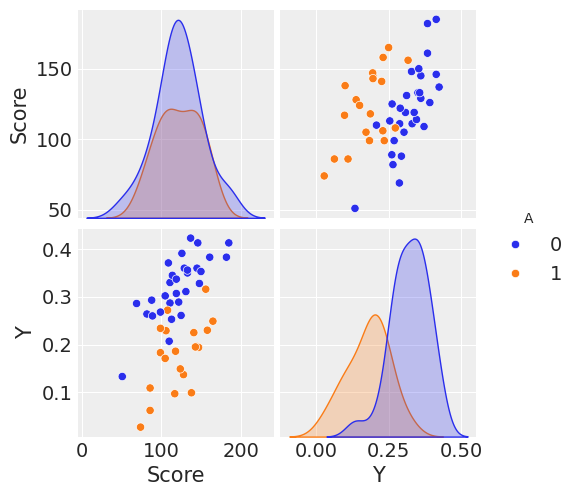

In [2]:
df = pd.read_csv("./data/data-attendance-1.txt")
display(df.head())
sns.pairplot(df, hue="A")

目的変数Yに対して説明変数がA(バイナリ)とScore(正の整数)がある感じ。

In [5]:
df_X = df[["A", "Score"]]
df_y = df["Y"]

In [7]:
with pm.Model() as model:
    # coords
    model.add_coord('obs_id', df_X.index)
    model.add_coord('var', df_X.columns)

    # data
    X = pm.Data("X", df_X, dims=('obs_id', 'var'))
    y = pm.Data("y", df_y, dims=('obs_id',))

    # define prior
    sigma = pm.HalfCauchy("sigma", beta=10)
    intercept = pm.Normal("intercept", mu=0, sigma=20)
    slope = pm.Normal("slope", mu=0, sigma=20, dims="var")

    # calc mu
    mu = pm.Deterministic("mu", intercept + pt.dot(X, slope), dims=('obs_id',))

    # likelihood
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y, dims=('obs_id',))

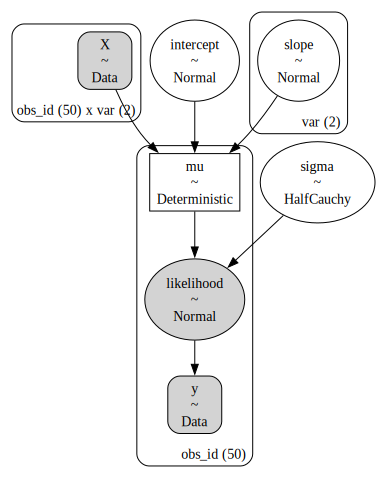

In [8]:
pm.model_to_graphviz(model)

In [9]:
with model:
    idata = pm.sample_prior_predictive(samples=50, random_seed=rng)

Sampling: [intercept, likelihood, sigma, slope]


<Axes: xlabel='likelihood'>

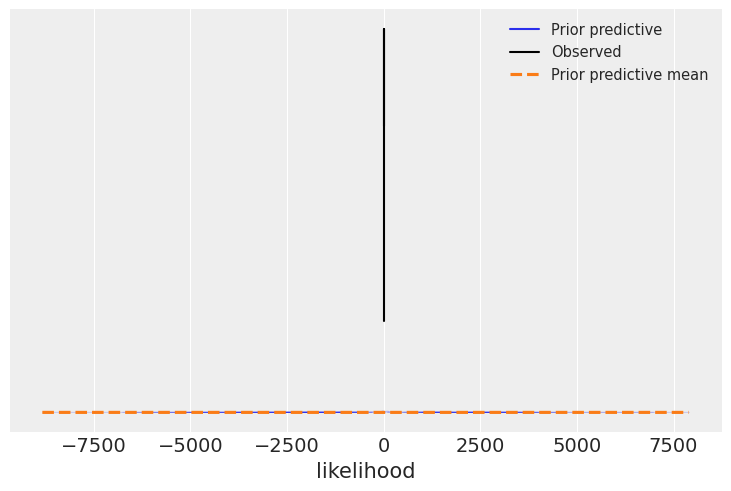

In [14]:
az.plot_ppc(idata, observed=True, group="prior")

Sampling: [intercept, likelihood, sigma, slope]


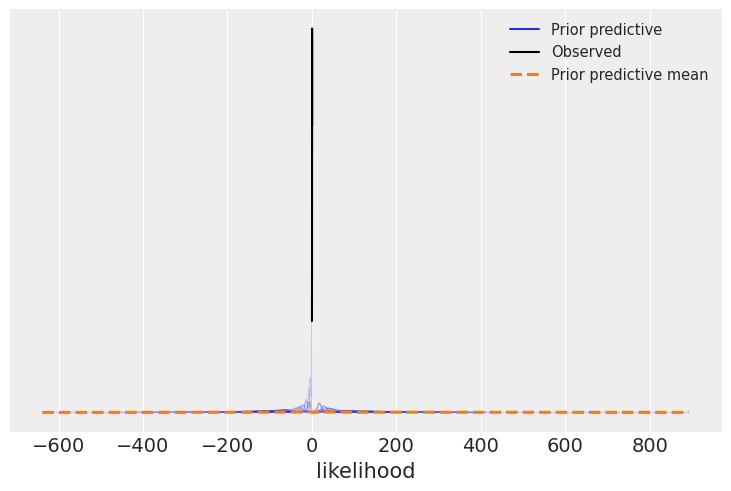

In [16]:
with pm.Model() as model:
    # coords
    model.add_coord('obs_id', df_X.index)
    model.add_coord('var', df_X.columns)

    # data
    X = pm.Data("X", df_X, dims=('obs_id', 'var'))
    y = pm.Data("y", df_y, dims=('obs_id',))

    # define prior
    sigma = pm.HalfCauchy("sigma", beta=1)
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    slope = pm.Normal("slope", mu=0, sigma=1, dims="var")

    # calc mu
    mu = pm.Deterministic("mu", intercept + pt.dot(X, slope), dims=('obs_id',))

    # likelihood
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y, dims=('obs_id',))

with model:
    idata = pm.sample_prior_predictive(samples=100, random_seed=rng)

az.plot_ppc(idata, observed=True, group="prior");

In [20]:
with model:
    idata = pm.sample(
        3000,
        tune=1000,
        nuts_sampler="numpyro",
        chains=4,
        idata_kwargs={"log_likelihood": True},
        random_seed=42,
        target_accept=0.90,
        return_inferencedata=True
        )

az.summary(idata, round_to=2)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.12,0.03,0.06,0.19,0.0,0.0,6222.52,5263.88,1.0
slope[A],-0.14,0.01,-0.17,-0.12,0.0,0.0,6396.30,6156.71,1.0
slope[Score],0.00,0.00,0.00,0.00,0.0,0.0,6552.93,5983.38,1.0
sigma,0.05,0.01,0.04,0.06,0.0,0.0,5898.17,5694.15,1.0
mu[0],0.24,0.02,0.21,0.27,0.0,0.0,6278.08,5877.95,1.0
mu[1],0.22,0.01,0.19,0.24,0.0,0.0,7772.77,8109.08,1.0
mu[2],0.33,0.01,0.31,0.34,0.0,0.0,8914.64,8344.00,1.0
mu[3],0.12,0.01,0.09,0.15,0.0,0.0,7189.86,6483.91,1.0
mu[4],0.24,0.01,0.21,0.26,0.0,0.0,7432.74,7793.23,1.0
mu[5],0.34,0.01,0.32,0.36,0.0,0.0,9344.76,8211.38,1.0


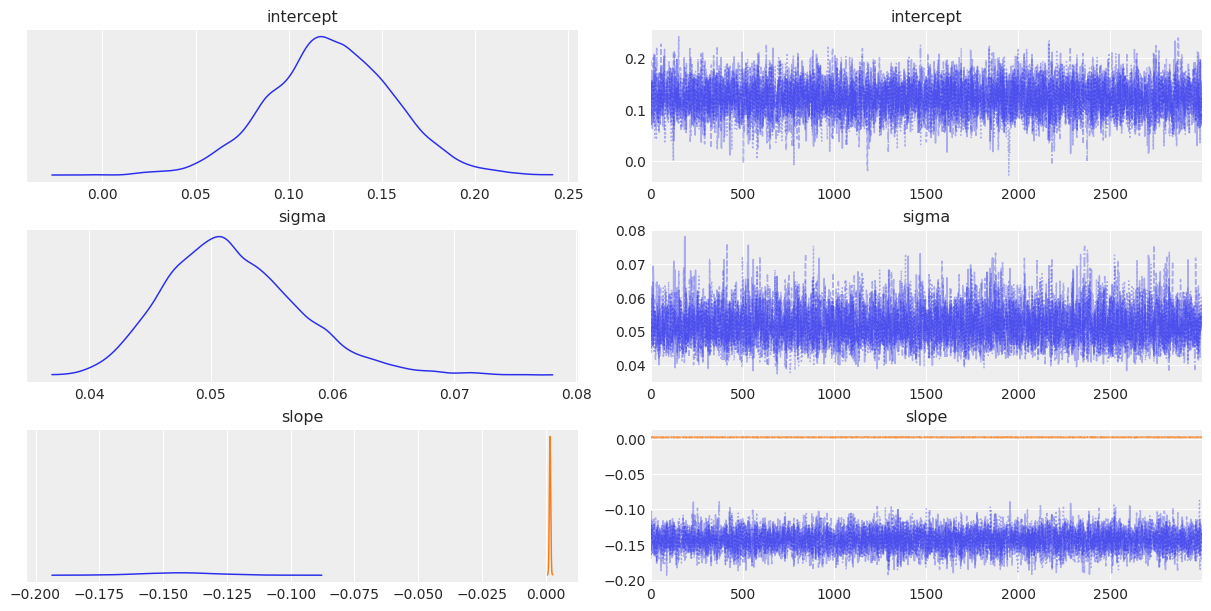

In [21]:
az.plot_trace(idata, combined=True, var_names=["intercept", "sigma", "slope"])

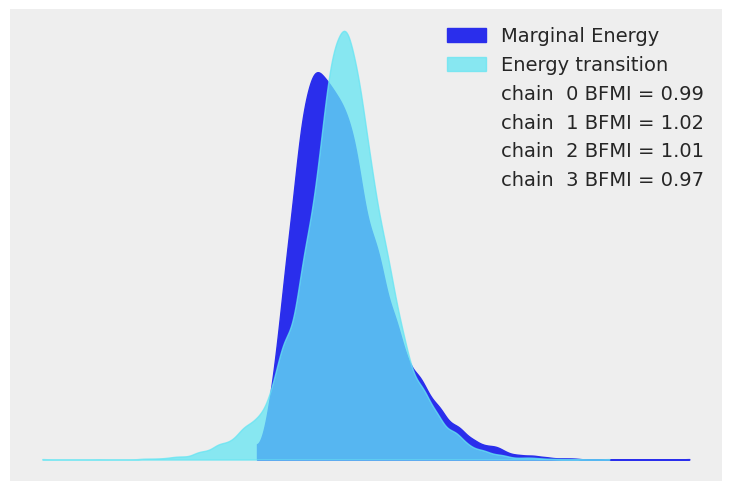

In [22]:
az.plot_energy(idata);

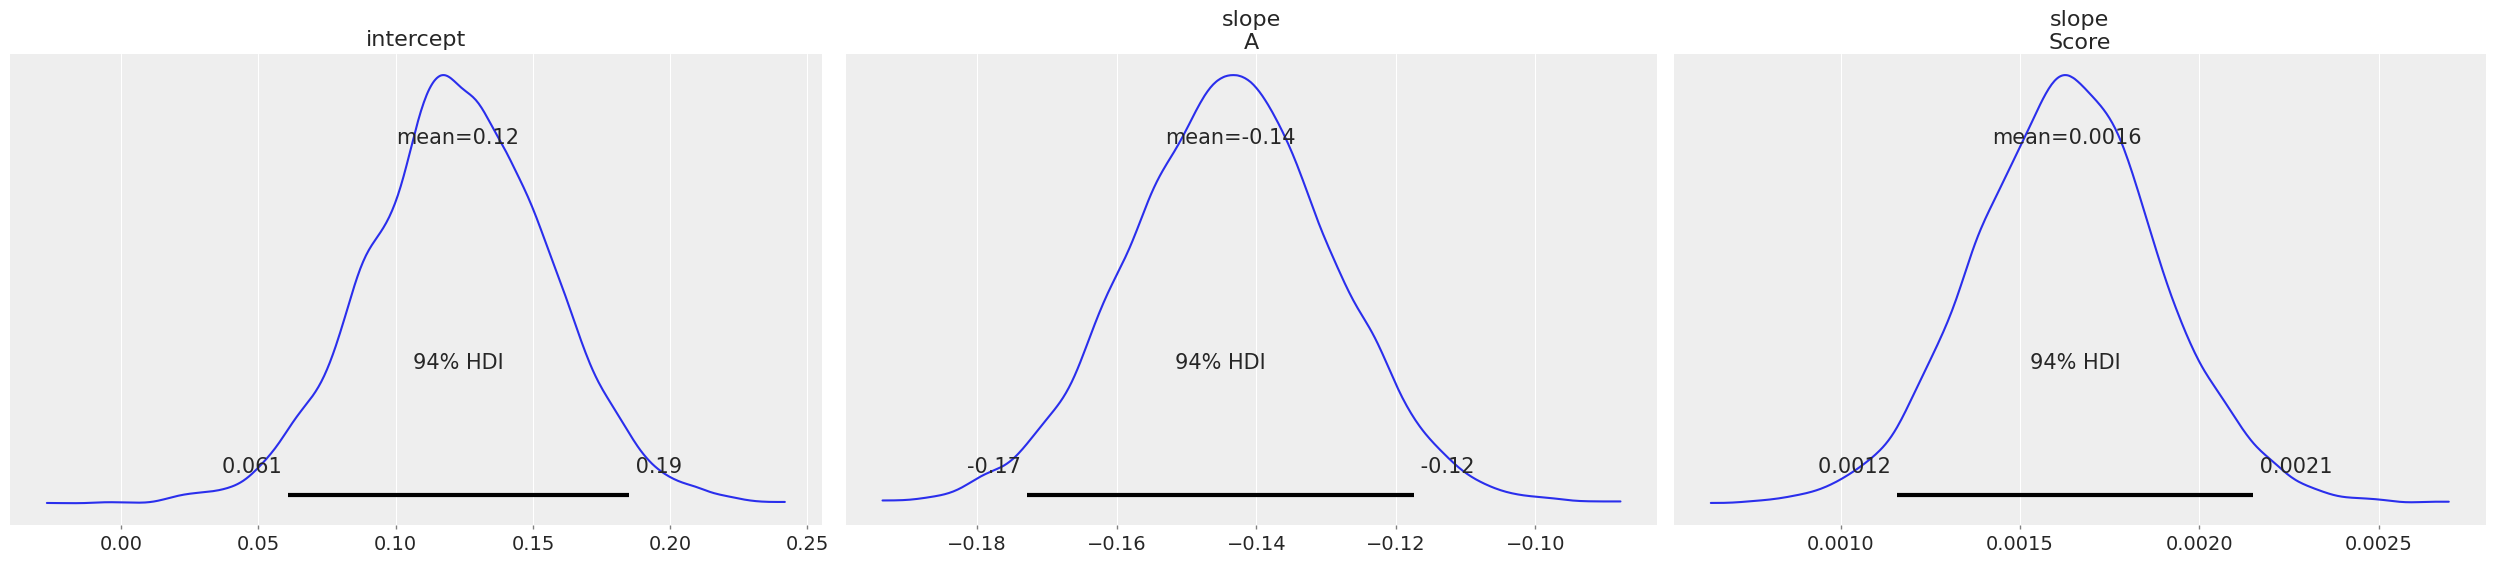

In [23]:
az.plot_posterior(idata, var_names=["intercept", "slope"]);

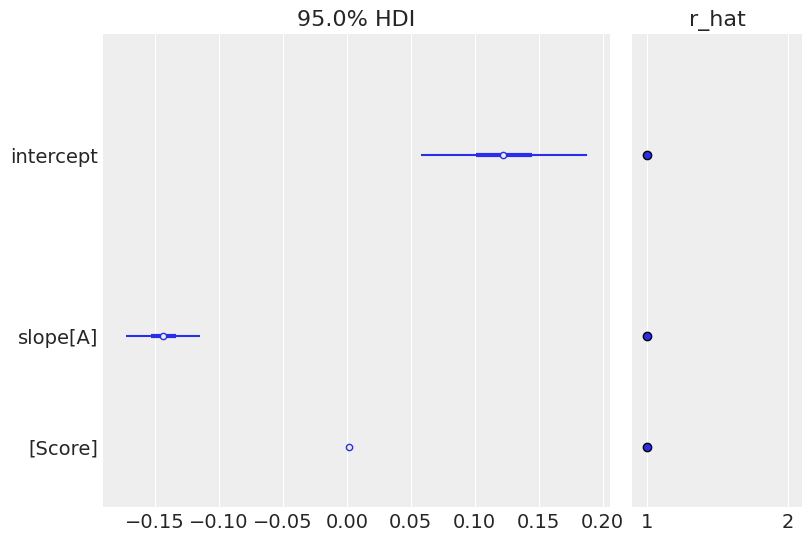

In [24]:
az.plot_forest(idata, var_names=["intercept", "slope"], combined=True, hdi_prob=0.95, r_hat=True);

In [26]:
X_new = df_X.tail()
with model:
    pm.set_data({"X": X_new, 'y': np.zeros(len(X_new))}, coords={"obs_id": X_new.index})
    idata.extend(pm.sample_posterior_predictive(idata))

idata

Sampling: [likelihood]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [27]:
idata.posterior_predictive["likelihood"].mean(dim=["draw", "chain"])

<xarray.DataArray 'likelihood' (obs_id: 5)> Size: 40B
array([0.29333707, 0.20492309, 0.36638772, 0.28414838, 0.13965532])
Coordinates:
  * obs_id   (obs_id) int64 40B 45 46 47 48 49

<Axes: xlabel='likelihood'>

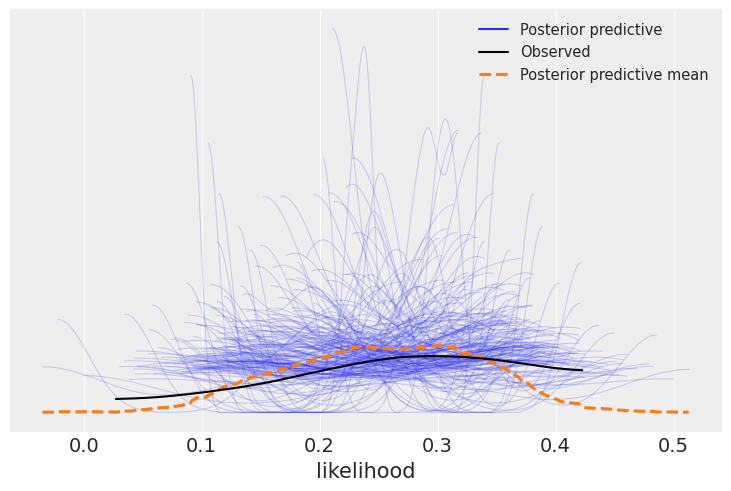

In [29]:
az.plot_ppc(idata, observed=True,num_pp_samples=200)